<img src="../../strathclyde_banner.png\" alt="University of Strathclyde" width="100%"/>

# 2. Sampling
----

## Table of Contents
* [2.1 Introduction](#introduction)
* [2.2 Sampling - How Fast?](#sampling_how_fast)
* [2.3 Sampling Theorem](#sampling_theorem)
* [2.4 Aliasing](#aliasing)
* [2.5 Anti-Aliasing](#anti_aliasing)
* [2.6 Reconstructing an Analogue Signal](#reconstructing_signal)
* [2.7 Zero Order Hold](#zero_order_hold)

## 2.1 Introduction<a class="anchor" id="introduction"></a>

Sampling is traditionally performed by an Analogue to Digital Converter (ADC). The process can be thought of as recording the voltage level of an analogue signal at an instant in time. This sample is assigned a binary number through a process called quantisation - more on that later. By collecting samples at a regular period, we can approximate an analogue signal on a digital system.

<a class="anchor" id="fig-1"></a>
<figure>
<img 
src="./images/ADC.png" style="width: 650px;"/>
    <figcaption><b>Figure 1:  </b></figcaption>
</figure>

The speed at which an ADC generates binary numbers is called the **sampling rate** or **sampling frequency**, $f_{s}$.

The time between samples is called the **sampling period**, $t_{s}$:

$ t_{s} = 1 / f_{s} $

Sampling frequency is quoted in samples per second, or simply as Hertz (Hz).

The actual sampling rate will depend on parameters of the application.
This may vary from:  
**10’s** of Hz for control systems,  
**100’s** of Hz for biomedical,  
**1000’s** of Hz for audio applications,  
**1,000,000’s** of Hz for IF digital radios,  
**1,000,000,000's** of Hz for RF digital radios.  

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import scipy.fftpack
from pystrath_dsp.helper_functions import *

This notebook is written for and runs on a digital system and therefore we cannot truthfully generate a continuous analogue signal. However, for the purposes of this notebook, we can approximate one by sampling it at a high rate.

In the following cell we will create a "continuous" sine wave of frequency 100 Hz. The formula for generating a sine wave is:

$ y(t) = Asin(2\pi ft + \phi) $

In [2]:
def sinewave(A,f,t,p,fs):
    x = np.arange(0, t, 1/fs)               # Discrete time i.e. sampled time period
    y = A * np.sin(2 * np.pi * f * x + p)   # Formula for sine wave
    return x,y

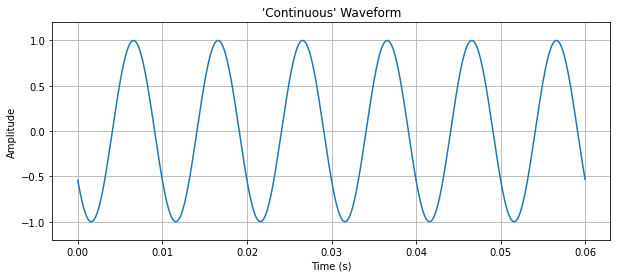

In [3]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.06    # Time
p = 10      # Phase

ar = 48000  # A high sample rate to approximate a continuous signal. ar = analogue rate

x_cont, y_cont = sinewave(A,f,t,p,ar)

ax = plot_timeseries("'Continuous' Waveform",
                        [x_cont], [y_cont],
                        ['continuous'])

## 2.2 Sampling - How Fast?<a class="anchor" id="sampling_how_fast"></a>

In order to ensure that we retain **all** of the information in the signal, what **sampling rate** should be used? 

<a class="anchor" id="fig-2"></a>
<figure>
<img 
src="./images/sampler.png" style="width: 650px;"/>
    <figcaption><b>Figure 2:  </b></figcaption>
</figure>

Below, we will sample the "continuous" 100 Hz signal at various sample rates and inspect the results.

Sampling at $f_{s}$=100 Hz, i.e. 1 sample per period:

In [4]:
def sample(y, fs):
    ar = 48000
    t = len(y)/ar
    x = np.arange(0, t, 1/fs)
    n = int(np.round(ar/fs))
    y_sampled = y[0::n]
    x = x[0:len(y_sampled)]
    return x, y_sampled

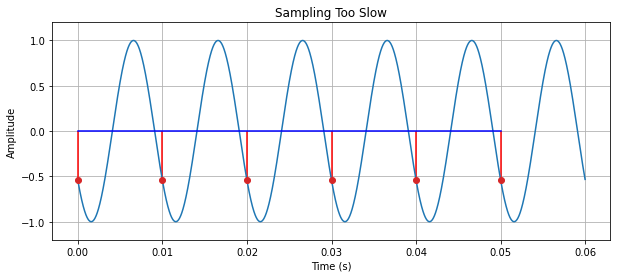

In [5]:
fs = 100    # 100 Hz (1 sample per period)

x, y = sample(y_cont, fs)

ax = plot_timeseries("Sampling Too Slow",
                        [x_cont, x], [y_cont, y], 
                        ['continuous', 'discrete'])

The signal here is interpreted as DC with an offset of -0.54 V. 

Sampling at $f_{s}$=80 Hz, i.e. 1 sample every 0.8 of a period:

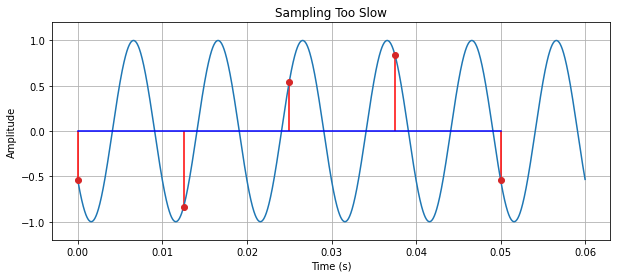

In [6]:
fs = 80    # 80 Hz (1 sample every 0.8 of a period)

x, y = sample(y_cont, fs)

ax = plot_timeseries("Sampling Too Slow",
                   [x_cont, x], [y_cont, y], 
                   ['continuous', 'discrete'])

Most of the signal features here are "missed". In both of these instances, the sampling rate is too slow to record enough of the signal's information to accurately reconstruct it. It can be observed in instances where the sampling rate is too low that the signal is interpreted as having a slower frequency. 

Sampling at $f_{s}$=800 Hz, i.e. 8 samples per period:

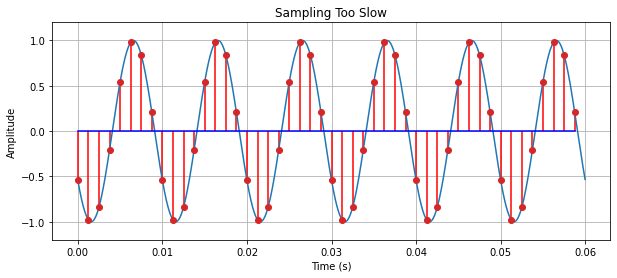

In [7]:
fs = 800    # 800 Hz (8 samples per period)

x, y = sample(y_cont, fs)

ax = plot_timeseries("Sampling Too Slow",
                   [x_cont, x], [y_cont, y], 
                   ['continuous', 'discrete'])

This appears to be a "reasonable" sample rate. 

Sampling at $f_{s}$=3000 Hz, i.e. 30 samples per period:

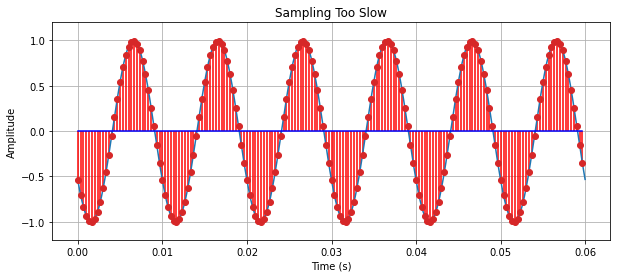

In [8]:
fs = 3000    # 3000 Hz (30 samples per period)

x, y = sample(y_cont, fs)

ax = plot_timeseries("Sampling Too Slow",
                   [x_cont, x], [y_cont, y], 
                   ['continuous', 'discrete'])

Perhaps this rate is higher than necessary.

Sampling too high will better approximate the original signal, however more samples will require more processing. So what is a "suitable" sampling rate? 

## 2.3 Sampling Theorem<a class="anchor" id="sampling_theorem"></a>

From mathematical theory, the minimum sampling rate required to retain all information is referred to as the **Nyquist frequency/rate**:

$f_{n}\ge 2 \times f_{max} $

where $f_{max}$ is the maximum frequency component of a **baseband**, **bandlimited** signal.

**Baseband:** The lowest signal frequency present is around 0 Hz:
<a class="anchor" id="fig-3"></a>
<figure>
<img 
src="./images/baseband.png" style="width: 600px; vertical-align: middle;"/>
    <figcaption><b>Figure 3:  </b></figcaption>
</figure>

**Bandlimited:** For all frequencies in the signal $f_{l}<f<f_h$:
<a class="anchor" id="fig-4"></a>
<figure>
<img 
src="./images/bandlimited.png" style="width: 600px; vertical-align: middle;"/>
    <figcaption><b>Figure 4:  </b></figcaption>
</figure>

## 2.4 Aliasing<a class="anchor" id="aliasing"></a>
When a (baseband) signal is sampled at a frequency below the Nyquist rate, then we “lose” the signal frequency information and aliasing is said to have occurred. 

Aliasing can be illustrated by sampling a sine wave at below the Nyquist rate and then “reconstructing”. We note that it appears as a sine wave of a lower frequency (aliasing - cf. impersonating).

Consider again sampling the 100 Hz size wave at 80 Hz: 

Desired frequency:	 100 Hz
Perceived frequency:	 20.0 Hz


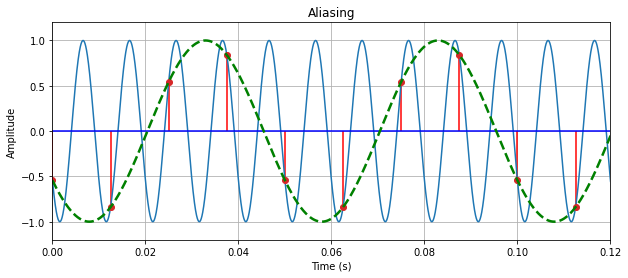

In [9]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.2     # Time
p = 10      # Phase

fs = 80     # Sampling frequency 
 
# 'Continuous' waveform
x_cont, y_cont = sinewave(A,f,t,p,ar)

# Sampled waveform 
x, y = sample(y_cont, fs)

# Perceived aliased waveform
f_alias = f-fs*np.round(f/fs)
x_alias, y_alias = sinewave(A,f_alias,t,p,ar)

ax = plot_timeseries("Aliasing",
                   [x_cont, x, x_alias], [y_cont, y, y_alias],
                   ['continuous', 'discrete', 'dash'],
                   xlim=0.12)
print("Desired frequency:\t", f, "Hz")
print("Perceived frequency:\t", f_alias, "Hz")

Observe that when the sampling rate does not obey the sampling theorem stated above, the perceived waveform is of a lower frequency. In the case of a desired frequency of 100 Hz and a sampling rate of 80 Hz, the perceived signal has a frequency of $f_{s}-f_{signal} = 20 Hz$.

<div class="alert alert-box alert-info">
Try changing the sampling rate and/or desired frequency above and observe the outcome of the perceived waveform.
</div>

To better illustrate this concept, we can inspect the frequency domain. Below, three cases are considered:

In [10]:
t = 0.5
fs = 1000
p = 0

A1 = 100
A2 = 1
A3 = 0.01

# Case 1
y1_cont = sinewave(A1,100,t,p,ar)[1] \
        + sinewave(A2,250,t,p,ar)[1] \
        + sinewave(A3,400,t,p,ar)[1]
x, y1 = sample(y1_cont, fs)

# Case 2
y2_cont = sinewave(A1,900,t,p,ar)[1] \
        + sinewave(A2,750,t,p,ar)[1] \
        + sinewave(A3,600,t,p,ar)[1]
x, y2 = sample(y1_cont, fs)

# Case 3
y3_cont = sinewave(A1,1100,t,p,ar)[1] \
        + sinewave(A2,1250,t,p,ar)[1] \
        + sinewave(A3,1400,t,p,ar)[1]
x, y3 = sample(y1_cont, fs)

In each case, three sinusoids of three different frequencies are summed together, giving a signal y. The range of frequencies, $y_{f}$, in each case is given as:    
**Case 1:** $0 > f_{y} > f_{s}/2$    
**Case 2:** $f_{s}/2 > f_{y} > f_{s}$   
**Case 3:** $f_{s} > f_{y} > 3f_{s}/2$

Plotting the frequency responses we can see how aliasing causes the components which do not obey Nyquist's Theorem to "fold" down across multiples of $f_{s}/2$ into the range  $0 - f_{s}/2$.

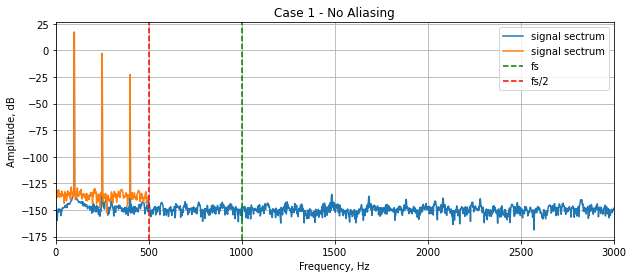

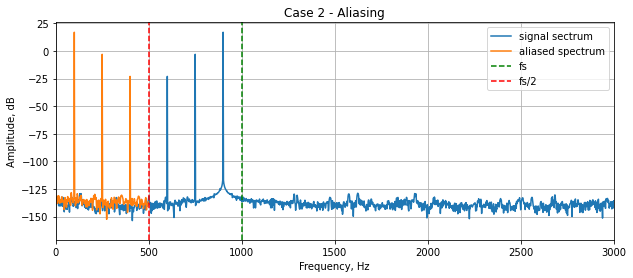

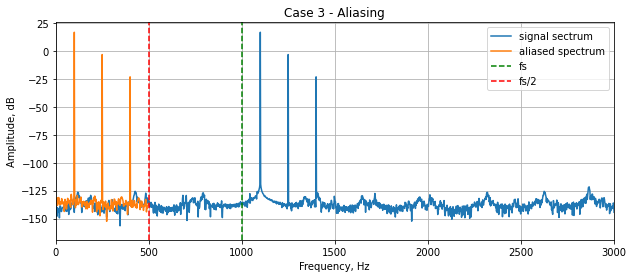

In [11]:
x_cont = np.arange(0, t, 1/ar) # 'Continuous'
freqs_cont = np.fft.fftshift(np.fft.fftfreq(len(x_cont),1/ar)) #frequency domain axis for graphs
freqs = np.fft.fftshift(np.fft.fftfreq(len(x),1/fs)) #frequency domain axis for graphs

title = "Case 1 - No Aliasing"
fft_cont = find_fft(y1_cont,len(x_cont))
fft_signal = find_fft(y1,len(x))
fft_plot = plot_fft([freqs_cont, freqs], [fft_cont, fft_signal], 
           fs, title, label=['signal sectrum', 'signal sectrum'])

title = "Case 2 - Aliasing"
fft_cont = find_fft(y2_cont,len(x_cont))
fft_signal = find_fft(y2,len(x))
fft_plot = plot_fft([freqs_cont, freqs], [fft_cont, fft_signal], 
           fs, title, label=['signal sectrum', 'aliased spectrum'])

title = "Case 3 - Aliasing"
fft_cont = find_fft(y3_cont,len(x_cont))
fft_signal = find_fft(y3,len(x))
fft_plot = plot_fft([freqs_cont, freqs], [fft_cont, fft_signal],
           fs, title, label=['signal sectrum', 'aliased spectrum'])

## 2.5 Anti-Aliasing<a class="anchor" id="anti_aliasing"></a>

Clearly, signals which contain frequency components greater than $f_{s}/2$ will result in aliasing when sampled. This can mean that after the signal has been reconstructed, you cannot be sure what the input signal was. The aliased components may also cause significant interference with your signal of interest. To avoid this, a lowpass filter is often employed immediately preceding the DAC, reffered to as an **anti-aliasing filter**. Put simply, this filter suppresses the energy of frequencies greater than $f_{s}/2$ such that they have little to no effect on the baseband spectrum when folded down. 

In the example below, three tones are present: 200 Hz, 1100 Hz, 2000 Hz. Our sampling rate is 2000 Hz. The signal we are interested in using within our digital system is the 200 Hz sinusoid. 

If we were to sample the analogue signal without filtering, aliasing would occur. The output of the cell below shows what the digitised waveform would look like in time and frequency domains.

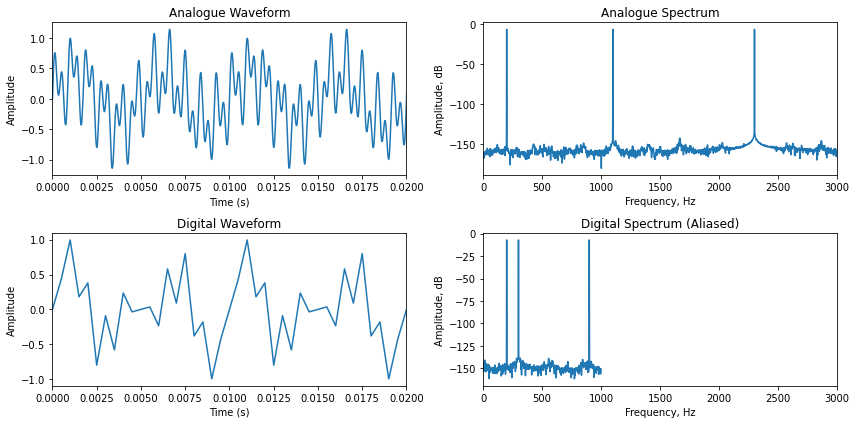

In [30]:
t = 0.5
fs = 2000
p = 0

A1 = 0.4
A2 = 0.4
A3 = 0.4

x_cont = np.arange(0, t, 1/ar) 
y_cont = sinewave(A1,200,t,p,ar)[1] \
       + sinewave(A2,1100,t,p,ar)[1] \
       + sinewave(A3,2300,t,p,ar)[1]
analogue = plot_timeseries("Analogue Waveform",
                              [x_cont], [y_cont], 
                              ['continuous'],
                              xlim=0.02)
plt.close()

title = "Analogue Spectrum"
fft_cont = find_fft(y_cont, len(x_cont))
fft_cont_plot = plot_fft([freqs_cont], [fft_cont],
                            ar, title)
plt.close()

x_samp, y_samp = sample(y_cont, fs)
sampled = plot_timeseries("Digital Waveform",
                             [x_samp], [y_samp], 
                             ['dash'],
                             xlim=0.02)
plt.close()

title = "Digital Spectrum (Aliased)"
freqs = np.fft.fftshift(np.fft.fftfreq(len(x_samp),1/fs)) #frequency domain axis for graphs
fft_samp = find_fft(y_samp,len(x_samp))
fft_plot_sampled = plot_fft([freqs], [fft_samp],
                               fs, title, label=['signal sectrum', 'aliased spectrum'])
plt.close()

subplot([analogue, fft_cont_plot, sampled, fft_plot_sampled], [2,2])

In order to ensure that the information in our signal of interest is preserved, a low pass filter is applied to the "analogue" signal before it is sampled.

In [32]:
def generate_lowpass(fs, cutoff, stop, numtaps):
    taps = signal.remez(numtaps, [0, cutoff, stop, 0.5*fs], [1, 0], Hz=fs)
    w, h = signal.freqz(taps, [1], worN=2000)
    return w, h, taps

The filter designed here has its stop band at $f_{s}/2$, meaning that any frequencies which are greater than $f_{s}/2$ and will cause aliasing have been suppressed.

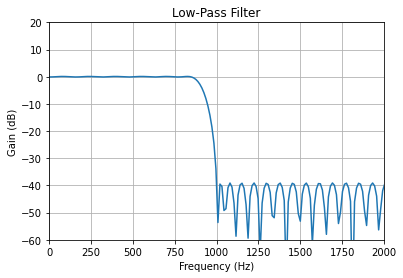

In [43]:
w, h, coeffs = generate_lowpass(ar, 850,1000, 600)
plot_response(ar, w, h, title = "Low-Pass Filter",xlim=fs)

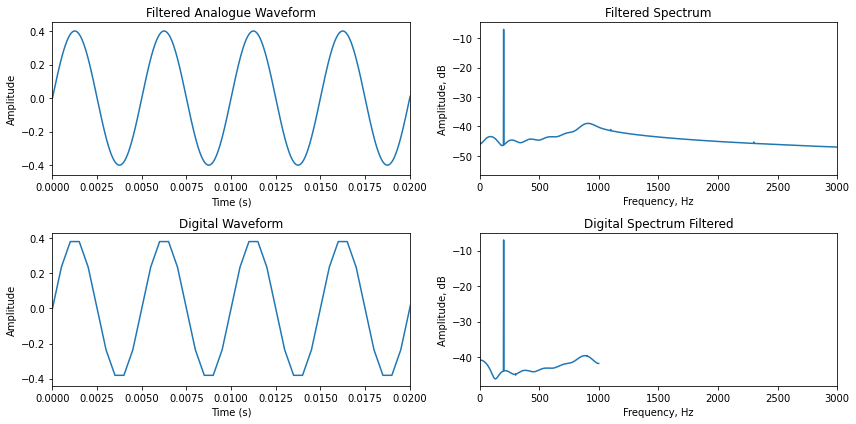

In [41]:
y_cont_samp = signal.filtfilt(coeffs, 1, y_cont)
analogue_filt = plot_timeseries("Filtered Analogue Waveform",
                              [x_cont], [y_cont_samp], 
                              ['continuous'],
                              xlim=0.02)
plt.close()

title = "Filtered Spectrum"
fft_filt = find_fft(y_cont_samp, len(x_cont))
fft_plot_filt = plot_fft([freqs_cont], [fft_filt],
                            fs, title, label=['signal sectrum', 'aliased spectrum'])
plt.close()

x_samp_filt, y_samp_filt = sample(y_cont_samp, fs)
sampled_filt = plot_timeseries("Digital Waveform",
                             [x_samp_filt], [y_samp_filt], 
                             ['dash'],
                             xlim=0.02)
plt.close()

title = "Digital Spectrum Filtered"
freqs = np.fft.fftshift(np.fft.fftfreq(len(x_samp_filt),1/fs)) #frequency domain axis for graphs
fft_samp_filt = find_fft(y_samp_filt,len(x_samp_filt))
fft_plot_samp_filt = plot_fft([freqs], [fft_samp_filt],
                               fs, title, label=['signal sectrum', 'aliased spectrum'])
plt.close()

subplot([analogue_filt, fft_plot_filt, sampled_filt, fft_plot_samp_filt], [2,2])

## 2.6 Reconstructing an Analogue Signal<a class="anchor" id="reconstructing_signal"></a>
Reconstruction is performed when converting a signal from the digital domain into analogue. A Digital to Analogue Converter (DAC) will hold the voltage value for a period of $ t_s$ for each of the samples, giving a "steppy" signal. 

<a class="anchor" id="fig-3"></a>
<figure>
<img 
src="./images/DAC.png" style="width: 650px;"/>
    <figcaption><b>Figure 3:  </b></figcaption>
</figure>

## 2.7 Zero Order Hold<a class="anchor" id="zero_order_hold"></a>
To model the signal reconstruction performed by a DAC, we can apply a zero order hold (ZOH) to the digital signal. The function below achieves this, given an input signal and a sampling frequency. 

The zero order hold function below first makes the signal "continuous" by zero padding the array to a rate of 48000 Hz - the rate we use to approximate an analogue signal in this notebook. This padded signal is then convolved with the impulse response of ZOH, which is a rectangular window of length, $ t_s $. 

Try changing the sampling rate to see the different outputs from the ZOH.

In [17]:
def zero_order_hold(signal, fs):
    # New time axis for 'continuous' signal
    x_zoh = np.arange(0, len(signal)/fs, 1/48000)
    
    # Zero pad the original signal to new rate
    y_zoh = np.zeros(len(x_zoh))
    y_zoh_indices = y_zoh[::int(np.round(48000/fs))]
    y_zoh_indices[0:len(signal)] = signal
    y_zoh[::int(np.round(48000/fs))] = y_zoh_indices
    
    # Create ZOH impulse response and convolve with input signal
    h_zoh = np.ones(int(48000/fs))
    y_zoh = np.convolve(h_zoh,y_zoh)
    
    # Chop off end to match time axis length
    y_zoh = y_zoh[0:len(x_zoh)] 
    
    return x_zoh, y_zoh

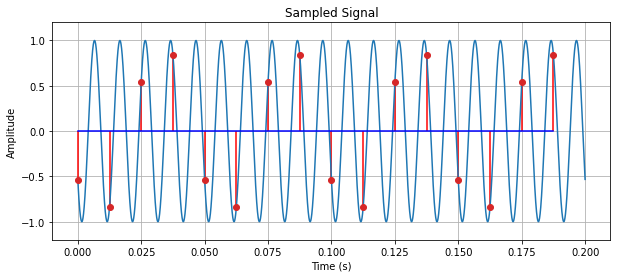

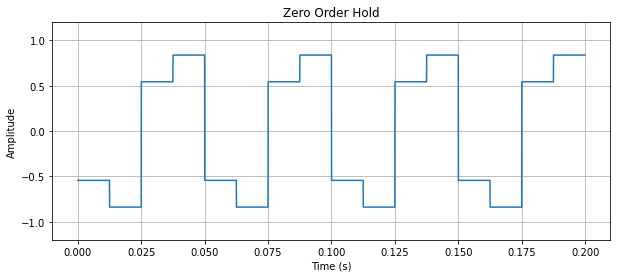

In [18]:
A = 1       # Amplitude
f = 100     # Desired frequency 
t = 0.2    # Time
fs = 80    # Sampling rate

# Define 'continuous' signal for comparison
x_cont = np.arange(0, t, 1/48000)            
y_cont = A * np.sin(2 * np.pi * f * x_cont + 10)  

# Sampled signal
x = np.arange(0, t, 1/fs)                # Discrete time i.e. sampled time period
y = A * np.sin(2 * np.pi * f * x + 10)   # Formula for sine wave

plot_timeseries("Sampled Signal",
                   [x_cont, x], [y_cont, y], 
                   ['continuous','discrete'])

# Perform ZOH on sampled signal
[x_zoh, y_zoh] = zero_order_hold(y, fs)
ax = plot_timeseries("Zero Order Hold", 
                        [x_zoh], [y_zoh], 
                        ['continuous'])

Note that the output is a little “steppy” caused by the zero order hold (step reconstruction). This artefact can however be removed with a **reconstruction filter**.

A reconstruction filter is implemented after the DAC with analogue circuitry. It removes the high frequencies present in the signal (in the form of the steps between the discrete levels).

Ideally reconstruction filters have very sharp cut off filters at frequency $f_{s}/2$. Steeper roll-off is more expensive, but clearly for many applications, good analogue filters are essential.

In a DSP system the accurately trimmed analogue filters could actually be more costly than the other DSP components, and their accuracy can be affected by temperature, ageing, etc. Therefore, it is desirable to do as much as possible of the filtering digitally.

To this end, we will first **interpolate** the sampled signal digitally before passing into our "analogue" reconstruction filter. 

The processes of interpolation is simply **upsampling** a signal followed by a **lowpass anti-imaging filter**. 

<!-- <img src="./images/upsample_3.png" style="width: 750px;"/> -->

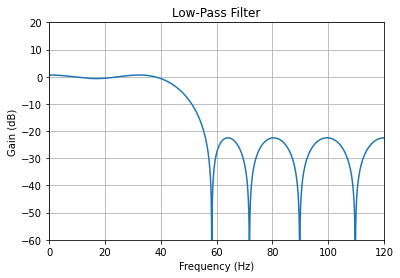

In [19]:
R = 3
Fs = fs*R
w, h, coeffs = generate_lowpass(Fs, fs/2, 1.4*(fs/2), 15)
plot_response(Fs, w, h, title = "Low-Pass Filter")

<AxesSubplot:title={'center':'Interpolated Signal, R = 3'}, xlabel='Time (s)', ylabel='Amplitude'>

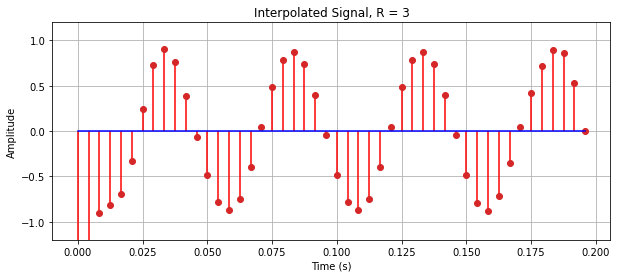

In [20]:
x_ov = np.arange(0, t, 1/(Fs))
y_ov = np.zeros(len(y)*R)
y_ov[::R] = y

y_lp = signal.filtfilt(coeffs, 1, y_ov) * R
plot_timeseries("Interpolated Signal, R = 3",
                   [x_ov], [y_lp],
                  ['discrete'])

<AxesSubplot:title={'center':'Zero Order Hold'}, xlabel='Time (s)', ylabel='Amplitude'>

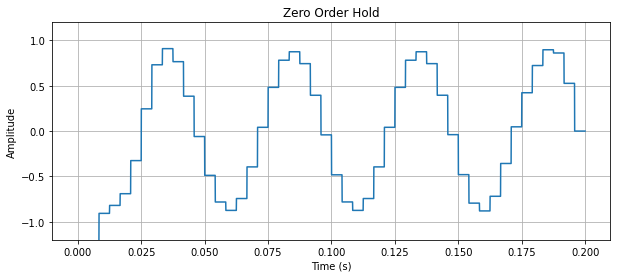

In [21]:
# Perform ZOH on sampled signal
[x_zoh, y_zoh] = zero_order_hold(y_lp, Fs)
plot_timeseries("Zero Order Hold",
                   [x_zoh], [y_zoh],
                   ['continuous'])

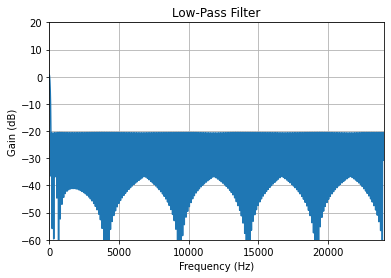

In [22]:
w, h, coeffs = generate_lowpass(48000, fs/2, Fs/2, 400)
plot_response(48000, w, h, title = "Low-Pass Filter")

<AxesSubplot:title={'center':'Reconstructed Signal'}, xlabel='Time (s)', ylabel='Amplitude'>

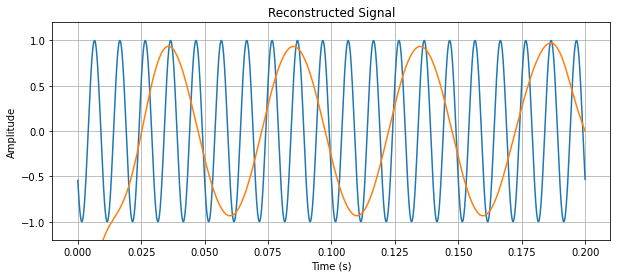

In [23]:
# [x_zoh, y_zoh] = zero_order_hold(y, fs)
y_recon = signal.filtfilt(coeffs, 1, y_zoh)
plot_timeseries("Reconstructed Signal",
                   [x_cont, x_zoh], [y_cont, y_recon],
                   ['continuous','continuous'])

## 2.8 Conclusion

[⬅️ Previous](01_introduction.ipynb) | | [Next ➡️](03_quantisation.ipynb)

----
----